In [15]:
import gzip
import json
import gc
import math
import random
import tensorflow as tf
import numpy as np
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
%%capture
!pip install funpymodeling
from funpymodeling.data_prep import todf
from funpymodeling.exploratory import freq_tbl, profiling_num,status

In [6]:
import os
os.getcwd()

'/home/facundo/Documents/Recommender-System'

In [5]:
# Load metadata from selected Items

import pickle
pkl_item_selec = 'meli_files/df_item_selec.pkl'
with open(pkl_item_selec,'rb') as f:
    df_items_select = pickle.load(f)
items_selection = df_items_select['item_id'].tolist()

In [9]:
df_items_select.head()

,item_id,title,domain_id,product_id,price,category_id,condition
6,369182,Funda Cartera Caseme 007 2 En 1 Huawei P30 Pro,MLM-CELLPHONE_COVERS,None,589.00,MLM167442,new
13,1714262,"Case Nintendo Galaxy M10, M20, M30, A10, A30, ...",MLM-CELLPHONE_COVERS,None,249.00,MLM167442,new
32,500249,Audifonos Jbl Pucks,MLM-HEADPHONES,None,1000.00,MLM7533,new
58,390343,Samsung Galaxy M10 Nuevo Dual Sim,MLM-CELLPHONES,14648835,2999.00,MLM1055,new
67,1079828,Case Escandalosos Huawei Y5 2018 Y6 2018 Y7 2...,MLM-CELLPHONE_COVERS,None,249.00,MLM167442,new


In [12]:
df_items_select['domain_id'].value_counts()

MLB-CELLPHONES               38390
MLB-HEADPHONES               11328
MLM-CELLPHONES                8035
MLM-CELLPHONE_COVERS          7475
MLB-CELLPHONE_SCREENS         6595
MLM-HEADPHONES                5731
MLB-CELLPHONE_ACCESSORIES     3177
MLM-CELLPHONE_ACCESSORIES     1720
Name: domain_id, dtype: int64

We can also do the same, but with the freq_tbl function, and it also gives us info about the percetage that each domain represents

In [14]:
domain_freq = freq_tbl(df_items_select['domain_id'])
domain_freq

,domain_id,frequency,percentage,cumulative_perc
0,MLB-CELLPHONES,38390,0.465610,0.465610
1,MLB-HEADPHONES,11328,0.137391,0.603001
2,MLM-CELLPHONES,8035,0.097452,0.700452
3,MLM-CELLPHONE_COVERS,7475,0.090660,0.791112
4,MLB-CELLPHONE_SCREENS,6595,0.079987,0.871099
5,MLM-HEADPHONES,5731,0.069508,0.940607
6,MLB-CELLPHONE_ACCESSORIES,3177,0.038532,0.979139
7,MLM-CELLPHONE_ACCESSORIES,1720,0.020861,1.000000


In [19]:
fig = px.histogram(domain_freq,y='domain_id',x='frequency')
fig.show()

Load data for training


In [20]:
pkl_datos = 'meli_files/data_seq.pkl'
with open(pkl_datos,'rb') as f:
    x_seq,y_seq = pickle.load(f)

In [21]:
x_seq

array([[      0, 1894398],
       [      0, 1730020],
       [1709387, 1983629],
       ...,
       [1702233,  165816],
       [ 235524, 1726723],
       [1399383,  492150]], dtype=int32)

In [22]:
y_seq

array([1591096, 1310157,  699581, ...,  242012,  485683, 2059288],
      dtype=int32)

### Encoding variables

In [23]:
#First, we encode the x variable
dim1,dim2 = x_seq.shape
seq_x_flat = x_seq.flatten()


In [24]:
from sklearn.preprocessing import LabelEncoder
le_x = LabelEncoder()
le_x.fit(seq_x_flat)
seq_x_flat_encoded = le_x.transform(seq_x_flat)

In [26]:
#Since we applied flatten() to our data for the LabelEncoder, now we need to reshape it with its original shape

seq_x_encoded = seq_x_flat_encoded.reshape([dim1,dim2])
seq_x_encoded

array([[    0, 12641],
       [    0, 11521],
       [11408, 13229],
       ...,
       [11361,  1076],
       [ 1508, 11496],
       [ 9238,  3157]])

In [28]:
y_seq.shape
#We don't need to flatten the y variable

(44129,)

In [29]:
le_y = LabelEncoder()
le_y.fit(y_seq)
seq_y_encoded = le_y.transform(y_seq)
seq_y_encoded

array([4869, 4007, 2093, ...,  697, 1388, 6352])

In [30]:
#Based on the given data, we set the following parameters
N_UNIQUE_INPUT=seq_x_flat_encoded.max()+1
N_UNIQUE_Y_ITEMS=seq_y_encoded.max()+1
SEQ_LEN = 2

print(N_UNIQUE_INPUT, N_UNIQUE_Y_ITEMS, SEQ_LEN)

14025 6488 2


## Model Creation

In [34]:
!pip3 install keras

In [36]:
from keras.layers import Input, Dense, Flatten, Input, Embedding, Add, Concatenate, Dropout
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow import keras
from keras.regularizers import l2


In [58]:
input = Input(shape=(SEQ_LEN),name='item')
x=Embedding(input_dim=N_UNIQUE_INPUT,
                output_dim=50,
                input_length=SEQ_LEN,name='embedding')(input)
#Here, we could also apply Flatten()(x), but we are going to use the lambda layer, as an alternative. Instead of concatenating them, it applies the mean

x= keras.layers.Lambda(lambda x:tf.reduce_mean(x,axis=1))(x)
x=Dropout(0.3)(x)
x=Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.3)(x)
x=Dense(16,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.3)(x)
x=Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
out_num=Dense(N_UNIQUE_Y_ITEMS,activation='softmax')(x)
final_model = Model(inputs=input,outputs=out_num)

In [59]:
final_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item (InputLayer)            [(None, 2)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 2, 50)             701250    
_________________________________________________________________
lambda_3 (Lambda)            (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528 

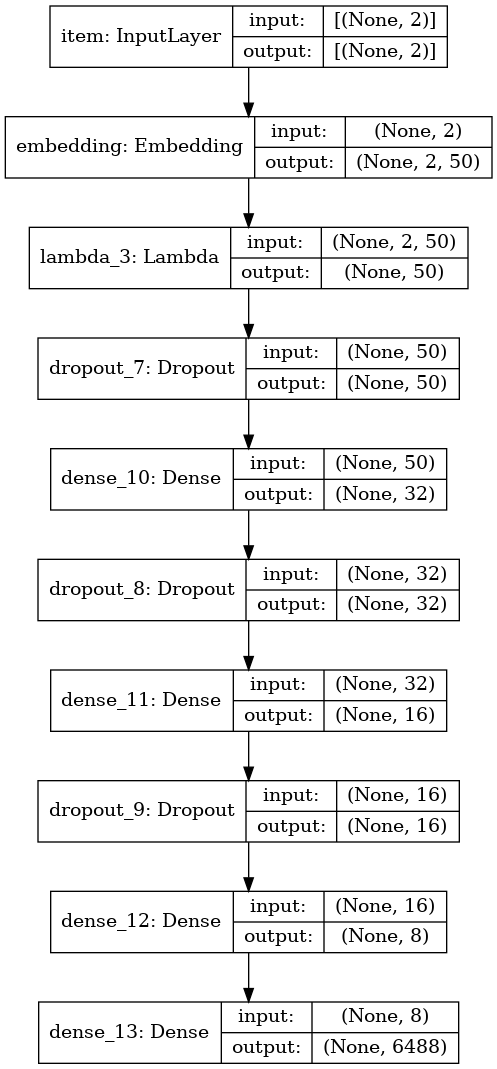

In [60]:
keras.utils.plot_model(final_model,show_shapes=True)

In [61]:
#We are also going to use Exponential Rate decay for our learning rate
#ACA TENES que cambiar el learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000, #cant casos train / batch size
    decay_rate=0.9,
    staircase=False
)
final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
loss=tf.keras.losses.sparse_categorical_crossentropy,
metrics='accuracy')

In [62]:
history = final_model.fit(x=seq_x_encoded,y=seq_y_encoded,epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
552/552 [==============================] - 16s 28ms/step - loss: 8.4197 - accuracy: 0.0062 - val_loss: 8.1520 - val_accuracy: 0.0105
Epoch 2/10
552/552 [==============================] - 14s 25ms/step - loss: 7.9244 - accuracy: 0.0085 - val_loss: 8.1052 - val_accuracy: 0.0114
Epoch 3/10
552/552 [==============================] - 14s 26ms/step - loss: 7.8218 - accuracy: 0.0086 - val_loss: 8.0902 - val_accuracy: 0.0101
Epoch 4/10
552/552 [==============================] - 14s 25ms/step - loss: 7.7230 - accuracy: 0.0081 - val_loss: 8.0979 - val_accuracy: 0.0104
Epoch 5/10
552/552 [==============================] - 14s 25ms/step - loss: 7.6801 - accuracy: 0.0089 - val_loss: 8.1297 - val_accuracy: 0.0109
Epoch 6/10
552/552 [==============================] - 15s 27ms/step - loss: 7.6515 - accuracy: 0.0096 - val_loss: 8.1046 - val_accuracy: 0.0144
Epoch 7/10
552/552 [==============================] - 14s 25ms/step - loss: 7.5796 - accuracy: 0.0116 - val_loss: 8.1018 - val_accuracy:

In [64]:
#Save the model
final_model.save('meli_files/final_modelNEW.h5')

## Finding similar items with embeddings
We need to look inside the embeddings layer

In [65]:
embeddings = final_model.layers[1].get_weights()[0]
embeddings.shape

(14025, 50)

In [66]:
embeddings

array([[ 0.30687016, -0.16490093, -0.5520465 , ...,  0.19188815,
         0.3231538 ,  0.33180162],
       [-0.44621012, -0.02557955, -0.4155053 , ..., -0.22203097,
        -0.36610204,  0.16314581],
       [-0.10357501, -0.09653623,  0.63586485, ...,  0.26958674,
         0.4502883 ,  0.16066621],
       ...,
       [-0.46101204,  0.46724445,  0.1808241 , ..., -0.49781772,
        -0.0133397 ,  0.01390812],
       [ 0.03319494, -0.08036657,  0.8952831 , ...,  0.15790546,
         0.06673274, -0.13901454],
       [-0.15928137,  0.14409155, -0.13527563, ..., -0.18732311,
        -0.05771157, -0.21380638]], dtype=float32)

In [67]:
pd.set_option('display.max_colwidth',0)

### KDTree
KDtree is quite useful to look for vectors inside viectors

In [69]:
#Save our files for Flask
prep_files = 'meli_files/prep_files.pkl'

if False:
    with open(prep_files,'wb') as f:
        pickle.dump([df_items_select,le_x,embeddings],f)
else:
    with open(prep_files,'rb') as f:
        df_items_select,le_x,embeddings = pickle.load(f)

In [70]:
from scipy import spatial
tree = spatial.KDTree(embeddings)

Given an encoded id, and how many similar elements, we can look it up in the tree

In [91]:
#1839
encoded_id_check = 8321
k_elements=3

dist, encoded_id = tree.query(embeddings[encoded_id_check], k=k_elements+1)

df_most_similar=pd.DataFrame({'dist':dist, 'encoded':encoded_id})
df_most_similar

,dist,encoded
0,0.000000,8321
1,0.200620,8700
2,0.507660,12322
3,0.548605,6113


We can also add a rank to this dataframe

In [94]:
#First we get rid of the first id, which is the same that we entered to look for similars (that's why dist is 0.000)
df_most_similar = df_most_similar[df_most_similar['encoded']!=encoded_id_check].copy()
df_most_similar['rank'] = list(range(1,k_elements+1))



In [95]:
df_most_similar

,dist,encoded,rank
1,0.200620,8700,1
2,0.507660,12322,2
3,0.548605,6113,3


In [96]:
#Now we get the item_id (the real one) with inverse_transform from the LabelEncoder()
similar_item_id = le_x.inverse_transform(df_most_similar['encoded'])
df_most_similar['item_id'] = similar_item_id 
df_most_similar

,dist,encoded,rank,item_id
1,0.200620,8700,1,1317531
2,0.507660,12322,2,1849208
3,0.548605,6113,3,925606


In [97]:
#Item that we want to search
df_items_select[df_items_select['item_id'].isin(le_x.inverse_transform([encoded_id_check]))][['item_id','title','domain_id','price']]

,item_id,title,domain_id,price
224600,1263482,Moto G7 Power Dual Sim 64 Gb Marine Blue 4 Gb Ram,MLM-CELLPHONES,3860.00


In [100]:
#Similar items that we find 
df_top_items = df_items_select[df_items_select['item_id'].isin(df_most_similar['item_id'])][['item_id','title','domain_id','price']]
df_top_items

,item_id,title,domain_id,price
307901,1317531,Moto G7 Play Dual Sim 32 Gb Índigo Oscuro 2 Gb Ram,MLM-CELLPHONES,2997.00
1283296,1849208,Celular Xiaomi Redmi Note 7 128 Gb /4 Gb Branco + Brindes,MLB-CELLPHONES,1199.00
1926651,925606,Celular Xiaomi Redmi Note 7 128 Gb / 4 Gb Branco + Brindes,MLB-CELLPHONES,1230.00


In [102]:
pd.merge(df_most_similar,df_top_items,on='item_id').sort_values('rank')

,dist,encoded,rank,item_id,title,domain_id,price
0,0.200620,8700,1,1317531,Moto G7 Play Dual Sim 32 Gb Índigo Oscuro 2 Gb Ram,MLM-CELLPHONES,2997.00
1,0.507660,12322,2,1849208,Celular Xiaomi Redmi Note 7 128 Gb /4 Gb Branco + Brindes,MLB-CELLPHONES,1199.00
2,0.548605,6113,3,925606,Celular Xiaomi Redmi Note 7 128 Gb / 4 Gb Branco + Brindes,MLB-CELLPHONES,1230.00


In [103]:
#Cosine similarity
from numpy import dot 
from numpy.linalg import norm 

def cos_sim(a,b):
    return dot(a,b)/(norm(a)*norm(b))
    

In [104]:
#An element that is quite similar, base on this formula
cos_sim1 = cos_sim(embeddings[encoded_id_check],embeddings[8700])
cos_sim1

0.9833204

In [107]:
cos_sim2 = cos_sim(embeddings[encoded_id_check],embeddings[7534])
cos_sim2

0.516615

In [120]:
#We can also make a function that, based on the real id, returns 3 similar elements as recommendation

def find_3similars(item_id):
    encoded_id_in = le_x.transform([item_id])[0]
    print('Requested id: {} - Encoded id: {}'.format(item_id,encoded_id_in))
    item_search = pd.DataFrame(df_items_select[df_items_select['item_id']==item_id][['item_id','title','domain_id','price']])
    
    k_elements = 3
    dist,encoded_id = tree.query(embeddings[encoded_id_in], k=k_elements+1)
    df_most_similar = pd.DataFrame({'dist':dist,'encoded_id':encoded_id})
    df_most_similar = df_most_similar[df_most_similar['encoded_id']!=encoded_id_in].copy()
    df_most_similar['rank'] = list(range(1,k_elements+1))
    #Now we apply the inverse_transform, to get the real id_s of the elements
    similar_item_id = le_x.inverse_transform(df_most_similar['encoded_id'])
    df_most_similar['item_id'] = similar_item_id
    #Now we get info about these 3 elements
    df_top_items = df_items_select[df_items_select['item_id'].isin(df_most_similar['item_id'])][['item_id','title','domain_id','price']]
    #Make a marge to add the rank colum
    df_similar_result = pd.merge(df_top_items,df_most_similar,on='item_id').sort_values('rank')
    return df_similar_result



In [121]:
find_3similars(293400)

Requested id: 293400 - Encoded id: 1882


,item_id,title,domain_id,price,dist,encoded_id,rank
1,1975280,Xiaomi Redmi Note 7 4 Gb 64 Gb Snapdragon 660 Octa Core 48mp,MLM-CELLPHONES,4995.92,0.469403,13188,1
2,971020,Smartphone Xiaomi Mi 8 Lite 6gb/128gb Dual Capa E Pelicula,MLB-CELLPHONES,1210.00,0.488578,6400,2
0,176043,Case Funda iPhone 6 7 8 Plus X Xs Max Xr Sirenita Disney 01,MLM-CELLPHONE_COVERS,259.00,0.497649,1143,3
